#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

**Импортируем библиотеки:**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Загружаю данные:**

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [3]:
df.sort_index(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Выполню ресемплирвоание данных по часу:**

In [5]:
df = df.resample('1H').sum()

**Проверю количество пропусков:**

In [6]:
print('Количество пропусков:')
print(df.isna().sum())

Количество пропусков:
num_orders    0
dtype: int64


**Удаляю дубликаты:**

In [7]:
df = df.drop_duplicates()
print(df.shape)

(251, 1)


**Построю график распределения значения для поля "num_orders"**

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Распределение количества заказов')

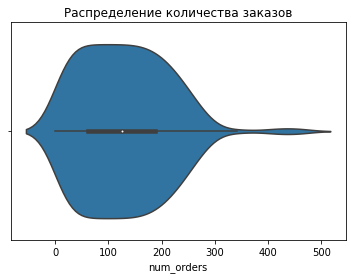

In [8]:
ax = sns.violinplot(df['num_orders'])
plt.title("Распределение количества заказов")

In [9]:
df = df.query('num_orders <= 400')

Удалю аномально большие значения количества заказов.

**Проверю типы данных:**

In [10]:
print(df.dtypes)

num_orders    int64
dtype: object


## Анализ

**Добавлю признаки**

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
make_features(df, 3, 10)

In [13]:
df

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,NaN
...,...,...,...,...,...,...,...,...
2018-08-30 10:00:00,227,8,30,3,232.0,217.0,265.0,239.4
2018-08-30 17:00:00,342,8,30,3,227.0,232.0,217.0,235.4
2018-08-31 00:00:00,276,8,31,4,342.0,227.0,232.0,245.8


**Построю графики распределения признаков**

Text(0.5, 1.0, 'Распределение количества заказов за весь период')

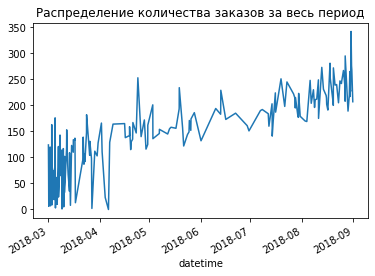

In [14]:
df['num_orders'].plot()
plt.title("Распределение количества заказов за весь период")

Количество заказов возрастает в летние месяцы и существенно увеличивается к концу лета. Скорее всего это связано с тем, что много людей возвращаются из отпусков.

**Проведу анализ признаков на сезонность**

***Месяц***

In [15]:
df_m = df.resample('1M').sum()

Text(0.5, 1.0, 'Распределение количества заказов по месяцам')

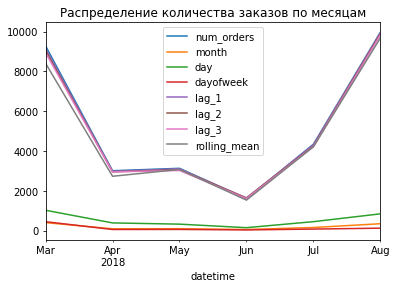

In [16]:
df_m.plot()
plt.title("Распределение количества заказов по месяцам")

Количество заказов увеличивается к концу лето, это и понятно, люди возвращаются из отпуска.

***Неделя***

In [17]:
df_n = df.resample('7D').sum()

Text(0.5, 1.0, 'Распределение количества заказов по неделям')

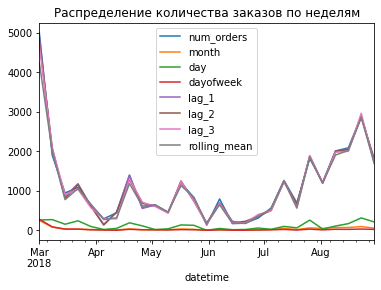

In [18]:
df_n.plot()
plt.title("Распределение количества заказов по неделям")

***День***

In [19]:
df_d = df.resample('1D').sum()

Text(0.5, 1.0, 'Распределение количества заказов по дням')

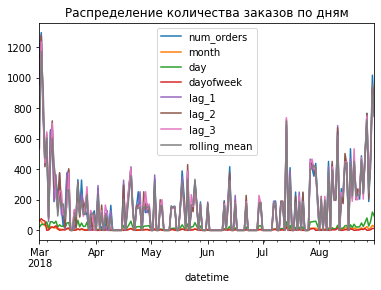

In [20]:
df_d.plot()
plt.title("Распределение количества заказов по дням")

**Час**

In [21]:
df_h = df.resample('1H').sum()

Text(0.5, 1.0, 'Распределение количества заказов в течение дня')

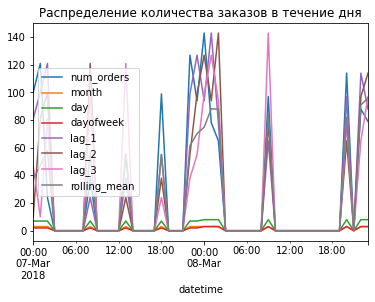

In [22]:
df_h['2018-03-07':'2018-03-08'].plot()
plt.title("Распределение количества заказов в течение дня")

Если бы это было обычное такси, то распределение выглядит так: с утра на работу, вечером с работы, в обед - по делам. А ночью - с вечеринки. Кажется, так.
А так как это заказы из аэропорта, то может тоже с рабочим графиком синхронизируются вызовы...

<AxesSubplot:xlabel='datetime'>

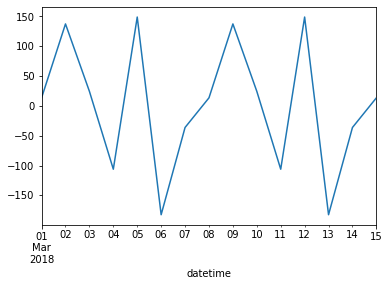

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
data = df['2018-03':'2018-09'].resample('1D').sum()

decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()

Максимальное количество вызовов такси наблюдается в первые дни недели: как правило, это понедельник. Это понятно, люди используют выходные по максимуму: съездили отдохнуть и возвращаются на работу.

**Разобью данные на выборки:**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2018-03-01 00:00:00 to 2018-08-31 18:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    248 non-null    int64  
 1   month         248 non-null    int64  
 2   day           248 non-null    int64  
 3   dayofweek     248 non-null    int64  
 4   lag_1         247 non-null    float64
 5   lag_2         246 non-null    float64
 6   lag_3         245 non-null    float64
 7   rolling_mean  238 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.5 KB


In [25]:
df_train, df_test = train_test_split(df, test_size=0.10, random_state=12345, shuffle=False) 
df_train = df_train.dropna()
df_test = df_test.dropna()
features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']
features_test = df_test.drop(['num_orders'], axis=1)
target_test = df_test['num_orders'] 

In [26]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213 entries, 2018-03-01 10:00:00 to 2018-08-18 00:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         213 non-null    int64  
 1   day           213 non-null    int64  
 2   dayofweek     213 non-null    int64  
 3   lag_1         213 non-null    float64
 4   lag_2         213 non-null    float64
 5   lag_3         213 non-null    float64
 6   rolling_mean  213 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.3 KB


In [27]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2018-08-18 02:00:00 to 2018-08-31 18:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         25 non-null     int64  
 1   day           25 non-null     int64  
 2   dayofweek     25 non-null     int64  
 3   lag_1         25 non-null     float64
 4   lag_2         25 non-null     float64
 5   lag_3         25 non-null     float64
 6   rolling_mean  25 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 1.6 KB


In [28]:
df_train, df_valid = train_test_split(df_train, test_size=0.10, random_state=12345, shuffle=False) 
df_valid = df_valid.dropna()
features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']
features_valid = df_valid.drop(['num_orders'], axis=1)
target_valid = df_valid['num_orders'] 

In [29]:
df_valid = df_valid.dropna()

In [30]:
features_valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2018-07-29 23:00:00 to 2018-08-18 00:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         22 non-null     int64  
 1   day           22 non-null     int64  
 2   dayofweek     22 non-null     int64  
 3   lag_1         22 non-null     float64
 4   lag_2         22 non-null     float64
 5   lag_3         22 non-null     float64
 6   rolling_mean  22 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 1.4 KB


In [31]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2018-03-01 10:00:00 to 2018-07-29 16:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         191 non-null    int64  
 1   day           191 non-null    int64  
 2   dayofweek     191 non-null    int64  
 3   lag_1         191 non-null    float64
 4   lag_2         191 non-null    float64
 5   lag_3         191 non-null    float64
 6   rolling_mean  191 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 11.9 KB


In [32]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2018-08-18 02:00:00 to 2018-08-31 18:00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         25 non-null     int64  
 1   day           25 non-null     int64  
 2   dayofweek     25 non-null     int64  
 3   lag_1         25 non-null     float64
 4   lag_2         25 non-null     float64
 5   lag_3         25 non-null     float64
 6   rolling_mean  25 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 1.6 KB


**Масштабирую признаки:**

In [33]:
numeric_columns = ['num_orders', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean']

In [34]:
features_numeric_columns = numeric_columns[1:8]
print(features_numeric_columns)

['month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean']


In [35]:
scaler=StandardScaler()
scaler.fit(features_train[features_numeric_columns])

features_train.loc[:, features_numeric_columns] = scaler.transform(features_train.loc[:, features_numeric_columns])
features_valid.loc[:, features_numeric_columns] = scaler.transform(features_valid.loc[:, features_numeric_columns])
features_test.loc[:, features_numeric_columns] = scaler.transform(features_test.loc[:, features_numeric_columns])

## Обучение

**Модель "Линейная регрессия"**

In [36]:
%%time
LR_model = LinearRegression()
LR_model.fit(features_train, target_train)
predictions_valid = LR_model.predict(features_valid)
LR_result = (mean_squared_error(target_valid, predictions_valid))** 0.5
print('RMSE модели линейной регрессии на валидационной выборке:', LR_result)

RMSE модели линейной регрессии на валидационной выборке: 32.33346269201392
CPU times: user 626 µs, sys: 7.16 ms, total: 7.78 ms
Wall time: 5.93 ms


In [43]:
len(target_valid)

22

In [44]:
len(predictions_valid)

22

**Модель "Дерево решений"**

In [37]:
%%time
DR_best_model = None
DR_best_result = 0
for depth in range(1, 10):
    DR_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    DR_model.fit(features_train, target_train)
    DR_predictions_valid= DR_model.predict(features_valid) 
    DR_result = (mean_squared_error(target_valid, DR_predictions_valid))** 0.5  
    if DR_result > DR_best_result:
        DR_best_model = DR_model
        DR_best_result = DR_result
        DR_best_depth = depth
        
print("RMSE модели дерево решений на валидационной выборке:", DR_best_result)
print("Наилучшее значение гиперпараметра:", DR_best_depth)

RMSE модели дерево решений на валидационной выборке: 47.90001984160807
Наилучшее значение гиперпараметра: 1
CPU times: user 33.7 ms, sys: 417 µs, total: 34.1 ms
Wall time: 32.2 ms


**Модель "Случайный лес"**

In [38]:
%%time
SL_best_model = None
SL_best_result = 0
SL_best_est = 0
SL_best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        SL_model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        SL_model.fit(features_train, target_train) 
        SL_predictions_valid = SL_model.predict(features_valid) 
        SL_result = (mean_squared_error(target_valid, SL_predictions_valid))** 0.5  
        if SL_result > SL_best_result:
            SL_best_model = SL_model
            SL_best_result = SL_result
            SL_best_est = est
            SL_best_depth = depth

print("RMSE модели дерево решений на валидационной выборке:", SL_best_result, "Количество деревьев:", SL_best_est, "Максимальная глубина:", depth)

RMSE модели дерево решений на валидационной выборке: 54.57126281463816 Количество деревьев: 20 Максимальная глубина: 10
CPU times: user 2.12 s, sys: 39.9 ms, total: 2.16 s
Wall time: 2.17 s


**Сводная таблица параметров**

In [39]:
duration_pr = {'Параметр': ['RMSE'],
       'Модель "Линейная регрессия"': [LR_result], 
       'Модель "Дерево решений"': [DR_best_result],
       'Модель "Случайный лес"': [SL_best_result],       
      }

duration_percent = pd.DataFrame(duration_pr, columns = ['Параметр', 'Модель "Линейная регрессия"', 
                                                        'Модель "Дерево решений"', 'Модель "Случайный лес"'])
duration_percent

,Параметр,"Модель ""Линейная регрессия""","Модель ""Дерево решений""","Модель ""Случайный лес"""
0,RMSE,32.333463,47.90002,54.571263


## Тестирование

**Перед тестированием моделей объединяю обучающую выборку и валидационную**

In [40]:
test_features_train = pd.concat([features_train, features_valid])
test_target_train = pd.concat([target_train, target_valid])

**Тестирование модели: "Линейная регрессия"**

In [ ]:
LR_model = LinearRegression()
LR_model.fit(test_features_train, test_target_train) 
LR_predictions_test = LR_model.predict(features_test) 
LR_result_test = (mean_squared_error(target_test, LR_predictions_test))** 0.5 
 
print("RMSE модели линейная регрессия на тестовой выборке:", LR_result_test)

**Тестирование модели: "Дерево решений"**

In [ ]:
DR_model = DecisionTreeRegressor(random_state=12345, max_depth=1) 
DR_model.fit(test_features_train, test_target_train) 
DR_predictions_test= DR_model.predict(features_test) 
DR_result_test = (mean_squared_error(target_test, DR_predictions_test))** 0.5 
print("RMSE модели дерево решений на валидационной выборке:", DR_result_test)

**Вывод:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Были построены модели для такого предсказания. 

Значение метрики *RMSE* на тестовой выборке получилось не больше 48.
Наилучшие показатели у моделей линейной регрессии. RMSE примерно равняется 36.